In [ ]:
from os.path import join
import torch 
torch.manual_seed(2)
from math import sqrt

from copy import deepcopy

import numpy as np
np.random.seed(2)

from scipy.stats import kstest, kruskal

import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.family']= 'open sans'

from rdn.defaults import default_goda_transformation, default_goda_filter
from rdn.fitting.models import LocalGaussModelTilde
from rdn.defaults import pardict_from_result

from rdn.validation import Simulation

In [2]:
t_idxes = [2, 20, 30, 40]
bins = [-15,-10,-5,0,5,10,15]

# Range we take for the visualization
lr = 11
ur = 15

# Stimulated index for the visualization
stim_idx = 350

Load the data

In [3]:
df = pd.read_pickle(
    'data/raw_data/raw_goda_data.pkl'
)

# Select the control condition and apply the default filtering
df = df[df['drug'] == 'Control']
df = default_goda_transformation(df)
df = default_goda_filter(df)

/home/janko/code/phd/rdn-project/src/rdn/defaults/defaultgodatransformation.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['nss'].replace({
/home/janko/code/phd/rdn-project/src/rdn/defaults/defaultgodatransformation.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['nss'].replace({


Simulate 7 distr

In [21]:
model = LocalGaussModelTilde()

model_p_dict = pardict_from_result(
    'output/multi_fitting/Multi_LocalGaussModelTilde/NLLAdast/1_3_5_7_Spine_data_fides_1200.hdf5', 
    Chi=1, dendrite_length=1000, N_mean=5000, run_index=0)


for stim_idxes in [torch.arange(110,390,40)]:
    simulation = Simulation(model = model,
                            model_p_dict = model_p_dict,
                            simulation_time = 40,
                            spine_number = 1000,
                            inter_spine_distance = 1,
                            stim_indexes = stim_idxes)

    _, _, rel_sizes_batch = simulation.run(50, seed=2021)


/home/janko/code/pyPESTO/pypesto/store/read_from_hdf5.py:124: UserWarning: You are loading a problem. This problem is not to be used without a separately created objective.
  warnings.warn(



Basal K distribution:
- Sample size: 59
- Mean: 4017.7537474693586 +- 2746.5237188826472
- Anderson test on log: AndersonResult(statistic=np.float64(0.36243150482356157), critical_values=array([0.543, 0.619, 0.742, 0.866, 1.03 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=np.float64(8.106764691950193), scale=np.float64(0.6245301761906116))
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

Basal N distribution:
- Sample size: 58
- Mean: 8070.943955026876 +- 5225.598876296613
- Anderson test on log: AndersonResult(statistic=np.float64(0.5003716373876728), critical_values=array([0.543, 0.618, 0.741, 0.865, 1.029]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=np.float64(8.820978310112448), scale=np.float64(0.5968557991311232))
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

Correlation matrix between log K_b and log

In [ ]:
def get_plot_series_from_df(df, bins, t_idx, summary):
    '''Auxiliary function to get the data to plot from the experimental
    dataframe.

    Summary: 'meansem,' or 'medianiq' 
        how to summarize the data 
    '''


    dff = df[(df['nss'] == -1) & (df['distance'] < 15)]

    # Take out the stimulated statistics
    sdff = dff[dff['type']=='Stim'][f'norm_{t_idx}']

    if summary=='medianiq':
        s_median = sdff.median()
        s_q1 = sdff.quantile(q=0.25)
        s_q3 = sdff.quantile(q=0.75)

    else:
        s_mean = sdff.mean()
        s_sem = sdff.sem()


    # Now the unstim binning
    dff = dff[dff['type']=='Spine']
    dff['Y'] = dff[f'norm_{t_idx}']

    dff['bin'] = pd.cut(dff['distance'], bins)
    tdff = dff[['bin','Y']]

    if summary=='medianiq':
        b_dff = dff.groupby('bin', observed=True).agg({'distance' : 'mean', 'Y' : ['median']})
        b_dff['Y','q1'] = tdff.groupby('bin', observed=True).quantile(q=0.25)
        b_dff['Y','q3'] = tdff.groupby('bin', observed=True).quantile(q=0.75)
        b_dff.loc[10] = [0, s_median, s_q1, s_q3]
    
    else: #if summary is meanstd
        b_dff = dff.groupby('bin', observed=True).agg({'distance' : 'mean', 'Y' : ['mean', 'sem']})
        b_dff.loc[10] = [0, s_mean, s_sem]

    # Add the stimulated bin again

    # Take the plotting data
    X_data = b_dff['distance', 'mean']

    if summary=='medianiq':
        Y_data = b_dff['Y', 'median']
        Y_q1_data = b_dff['Y', 'q1']
        Y_q3_data = b_dff['Y', 'q3']
        Y_el_data = Y_data-Y_q1_data
        Y_eh_data = Y_q3_data-Y_data
    
        return X_data, Y_data, Y_el_data, Y_eh_data

    else:
        Y_data = b_dff['Y', 'mean']
        Y_sem = b_dff['Y', 'sem']

        return X_data, Y_data, Y_sem, Y_sem




def get_plot_series_from_simulation(rel_sizes_batch, lr, ur, stim_idx, t_idx, summary):
    '''Auxiliary function to get the data to plot from the experimental
    dataframe.
    Notice that it returns not the errors but the 1 and 3 quantiles, since they
    will be used with fillbetween
    '''

    
    # Extract data for plotting
    X = np.arange(-lr, ur)
    Y_batch = rel_sizes_batch[t_idx, stim_idx-lr:stim_idx+ur]

    if summary=='medianiq':
        Y, _ = Y_batch.median(axis=1)
        Y_1q = torch.quantile(Y_batch, 0.25, axis=1)
        Y_3q = torch.quantile(Y_batch, 0.75, axis=1)
        
        return X, Y, Y_1q, Y_3q

    else:
        Y = Y_batch.mean(axis=1)
        Y_sem = Y_batch.std(axis=1)/sqrt(Y_batch.shape[1])
        
        return X, Y, Y_sem, Y_sem


# Transform in percentages
def ttp(*data):
    '''transform to percentages'''
    res = []
    for d in data:
        res.append(d*100)
    return res

def ttc(*data):
    '''transform to changes'''
    res = []
    for d in data:
        res.append(d-1.)
    return res


def plot_prediction_plot(
    ax, df, rel_sizes_batch, bins, lr, ur, stim_idx, t_idx,
    summary='medianiq',
    **kwargs
):
    '''The main plot function (plots the classic prediction vs data)'''

    # Pure data
    dff = df[(df['nss'] == -1) & (df['distance'] < 15)]
    ax.scatter(dff['distance'], dff[f'norm_{t_idx}'], alpha=0.1, c='gray',
               linewidths=0, s=kwargs.get('s'),)


    # Prediction
    X, Y, Y_1q, Y_3q = get_plot_series_from_simulation(
        rel_sizes_batch,
        lr,
        ur,
        stim_idx, 
        t_idx,
        summary=summary,
    )

    ax.errorbar(
        X, Y, 
        fmt='-o',
        linewidth=1,
        markersize=kwargs.get('smarkersize'),
        label=r'Prediction',
    )

    ax.fill_between(X, Y_1q, Y_3q, alpha=0.15)
    ax.axhline(y=1, linewidth=1, linestyle=(0,(5,5)), c='black')

    
    # Binned data
    X_data, Y_data, Y_el_data, Y_eh_data = get_plot_series_from_df(
        df, bins, t_idx, summary=summary
    ) 

    ax.errorbar(X_data,
                Y_data,
                yerr=(Y_el_data, Y_eh_data),
                fmt='D',
                c='black',
                mfc='black',
                mew=0,
                markersize=kwargs.get('markersize'),
                capsize=0,
                linewidth=2,
                label=r'Experiment',
                zorder=100,
                )
                



def plot_distribution_plot(axs, df, rel_sizes_batch, stim_idx, t_idx):

    bins = 20

    ## Right panel, upper
    ax = axs[0]
    ax.hist(rel_sizes_batch[t_idx, stim_idx,:].flatten(), 
            bins=bins,
            density=True,
            label='Prediction',
            )

    ## Right panel, lower
    ax = axs[1]
    dff = df[(df['nss'] == -1) & (df['distance'] < 15)]
    sdff = dff[dff['type']=='Stim'][f'norm_{t_idx}']

    Y = (sdff).to_numpy()
    Y_sim = rel_sizes_batch[t_idx, stim_idx,:].flatten()

    ax.hist(Y, bins=bins, density=True, color='black', align='right',
            label='Experiment',)

    print(len(Y), len(Y_sim))
    print(kstest(Y,Y_sim))



In [8]:
def plot_upper_section(fig):
    gs = fig.add_gridspec(6,5, width_ratios=(0.5,0.15,1,0.1,0.5))

    axs = []
    axu = fig.add_subplot(gs[0:3,0])
    axd = fig.add_subplot(gs[3:,0])
    axs += [axu, axd]
    axs.append(fig.add_subplot(gs[:,2]))

    axs += [
            fig.add_subplot(gs[:2,4]),
            fig.add_subplot(gs[2:4,4]),
            fig.add_subplot(gs[4:,4]),
            ]


    distr_axs = axs[:2]
    plot_distribution_plot(distr_axs, df, rel_sizes_batch, stim_idx, 2)

    center_ax = axs[2]
    plot_prediction_plot(center_ax, df, rel_sizes_batch, bins, lr, ur, stim_idx,
                            2, linewidth=3, markersize=8, capsize=2, s=10,
                            summary='medianiq')

    right_axs = axs[3:]
    plot_prediction_plot(right_axs[0], df, rel_sizes_batch, bins, lr, ur,
                            stim_idx, 10, linewidth=2, markersize=4, capsize=0,s=3,
                            smarkersize=4, summary='medianiq')

    plot_prediction_plot(right_axs[1], df, rel_sizes_batch, bins, lr, ur,
                            stim_idx, 30, linewidth=2, markersize=4, capsize=0, s=3,
                            smarkersize=4, summary='medianiq')

    plot_prediction_plot(right_axs[2], df, rel_sizes_batch, bins, lr, ur,
                            stim_idx, 40, linewidth=2, markersize=4, capsize=0, s=3,
                            smarkersize=4, summary='medianiq')

    # Cosmetics
    # Distributions
    distr_axs[0].set_xticklabels([])
    distr_axs[0].set_title('Post-basal ratio distributions', pad=10)
    distr_axs[1].set_xlabel('Post-basal ratio at\nstimulation (2 min)', size=12,
                            labelpad=3,)
    for ax in distr_axs:
        ax.set_ylabel('pdf', size=12, labelpad=5)
        ax.set_xlim(0.3,4)
        ax.set_xticks([1,3])
        ax.set_ymargin(.8)
        ax.set_yticks([])
        ax.legend(frameon=False, loc=(0,0.6), fontsize=12)


    # Central ax
    ax = center_ax
    ax.legend(frameon=False, ncols=2, loc='upper center', fontsize=12)
    ax.set_xlim(-12,14)
    ax.set_ylim(.7,1.9)
    ax.set_xticks([-10,-5,0,5,10])

    ax.set_title('Plasticity profile at 2 minutes', pad=10)
    ax.set_xlabel(r'Spine position $[\mu m]$', fontsize=12)
    ax.set_ylabel(r'Post-basal ratio', fontsize=12, labelpad=10)

    # Right section
    for idx, (ax, t) in enumerate(zip(right_axs, [10,20,40])):
        ax.set_xlim(-12,14)
        ax.set_ylim(.6,1.9)
        ax.set_yticks([1])
        if idx == 0 or idx == 1: ax.set_xticklabels([])
        ax.text(16, 1.2, f'{t} min')

    right_axs[0].set_title('Plasticity profile in time', pad=10)

    ax = right_axs[-1]
    ax.set_xticks([-10,0,10])
    ax.set_xlabel(r'Spine position $[\mu m]$', fontsize=12)
    ax.text(-15.5, 1.4, 'Post-basal ratio', rotation=90, va='bottom', ha='right',
            fontsize=12)

This can all be wrapped in a bit plotter function. Lets see the simulations

In [ ]:
def plot_lower_section(fig):
    
    def plot_plasticity_column(axs, stim_idxes, spine_number):
        mpd = model_p_dict


        def induction_profile(x, stim_idxes, kn):

            total = np.zeros_like(x, dtype=float)

            for xs in stim_idxes:
                total += (
                    mpd[f'{kn}s'] * 
                    np.exp(-(x-xs)**2/mpd[f'sigma_{kn}'])
                )

            return total*np.exp(-2/mpd[f'tau_{kn}'])/10000


        simulation = Simulation(model = model,
                                model_p_dict = model_p_dict,
                                simulation_time = 40,
                                spine_number = spine_number,
                                inter_spine_distance = 1,
                                stim_indexes = stim_idxes
                                )

        _,_,rsb, _,kbs, _,nbs = simulation.run_return_all(100, seed=1)

        X_fine = np.linspace(0,spine_number,100)
        X = np.arange(0,spine_number)

        qs = torch.tensor([0.25,0.5,0.75], dtype=torch.float64)

        q1, Y, q3 = torch.quantile(
            rsb[2,:,:],
            qs,
            axis=1,
            keepdim=True,
        )

        ax = axs[0]
        ax.errorbar(
            X,Y, fmt='-o',
            linewidth=1,
        )
        
        ax.fill_between(
            X,
            q1.squeeze(),
            q3.squeeze(),
            alpha=0.2
        )

        ax.axhline(
            y=1,
            c='black',
            linewidth=1,
            linestyle=(0,(5,5))
        )

        ax = axs[1]
        ax.plot(
            X_fine, induction_profile(X_fine, stim_idxes, 'K'),
            c='forestgreen',
            linewidth=2,
            alpha=1,
            label=r'Induced kinases $K$'
        )

        ax.plot(
            X_fine, induction_profile(X_fine, stim_idxes, 'N'),
            color='mediumvioletred',
            linewidth=2,
            alpha=0.5,
            label=r'Induced phosphatases $N$'
        )

        ax = axs[2]
        ax.plot(
            X_fine,
            (
                induction_profile(X_fine, stim_idxes, 'K')/
                induction_profile(X_fine, stim_idxes, 'N')
            ),
            linewidth=2,
            alpha=1,
            label=r'Ratio of induced $K/N$',
            c='purple',
        )

        avg_kn_ratio = (kbs[2]/nbs[2]).mean()
        avg_kn_sem = (kbs[2]/nbs[2]).std()/sqrt(len(kbs[2]))

        ax.axhline(
            avg_kn_ratio,
            linestyle=(0,(5,3)),
            linewidth=1,
            label=r'Average basal ratio $K_b/N_b$',
            c='purple',
        )

        return (
            stim_idxes[1]-stim_idxes[0],
            Y[stim_idxes[0]+1:stim_idxes[1]].mean()
        )


    spine_number=20
    stim_idxess = [
        [10-i,10+i] for i in [1,2,3,4]
    ]

    isds = []
    Ys = []


    ### PLOTTING ###

    axs = fig.subplots(3,4, height_ratios=(2,1,1), sharex=True)

    for stim_idxes, col in zip(stim_idxess, axs.T):
        isd, mean_ic_rs = plot_plasticity_column(col, stim_idxes, spine_number)

        isds.append(isd)
        Ys.append(mean_ic_rs)

    for ax in axs.flatten(): ax.set_xlim(0,spine_number)

    for ax in axs[0]: 

        ax.set_ylim(0.7,1.9)
        for k,v in ax.spines.items():
            if k != 'bottom': v.set_visible(False)
        ax.set_yticks([1,1.5])

    for ax in axs[1]:
        ax.set_ylim(-0.5,3)
        ax.ticklabel_format(axis='y', scilimits=(0,1))
        for k,v in ax.spines.items():
            if k != 'bottom': v.set_visible(False)
        ax.set_yticks([0,1.5,3])

    for ax in axs[2]:
        ax.set_ylim(-0.3,1.1)
        ax.set_xlabel(r'Spine position [$\mu m$]', size=12)
        for k,v in ax.spines.items():
            if k != 'bottom': v.set_visible(False)
        ax.set_yticks((0,0.5,1))


    axs[1,1].legend(frameon=False, ncols=2, loc=(0.1,1.1), fontsize=11)
    axs[2,1].legend(frameon=False, ncols=2, loc=(0,1), fontsize=12)

    axs[0,0].set_ylabel('Post-basal\nratio', size=12, labelpad=14)
    axs[1,0].set_ylabel('Induced\ncatalysts '+r'($\cdot 10^4)$', size=12, labelpad=14)
    axs[2,0].set_ylabel('Induced\nratio', size=12, labelpad=14)
    axs[0,0].set_title('Inter-stimulus distance '+r'$2 \,\mu m$', weight='regular')
    axs[0,1].set_title('Inter-stimulus distance '+r'$4 \,\mu m$')
    axs[0,2].set_title('Inter-stimulus distance '+r'$6 \,\mu m$')
    axs[0,3].set_title('Inter-stimulus distance '+r'$8 \,\mu m$')

53 50
KstestResult(statistic=np.float64(0.3392452830188679), pvalue=np.float64(0.0037408373098625197), statistic_location=np.float64(1.4021528525296016), statistic_sign=np.int8(1))


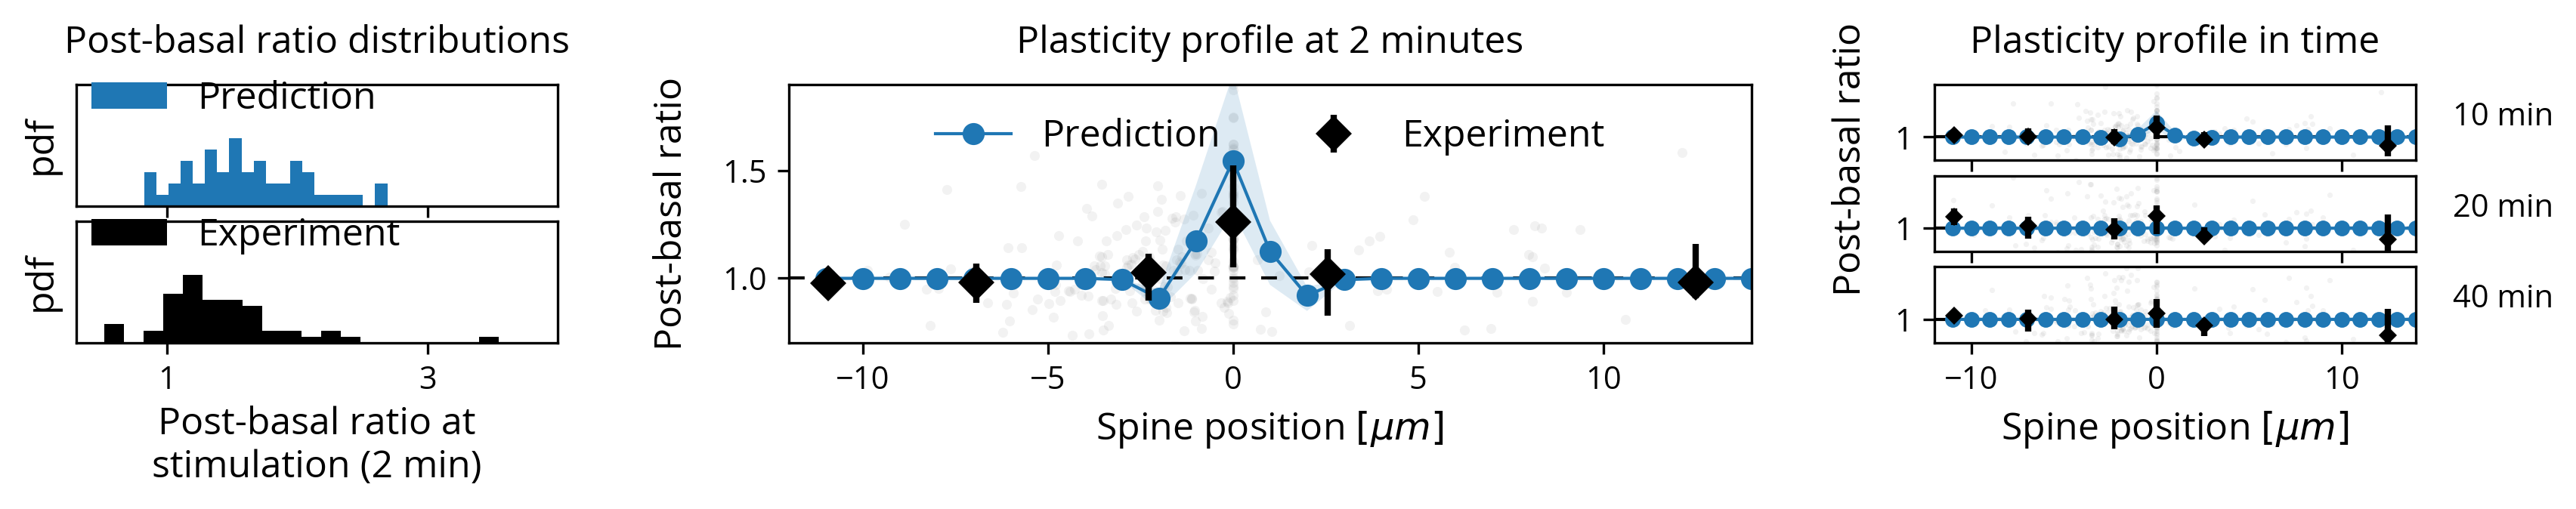

In [ ]:
fig = plt.figure(figsize=(12,2), dpi=300)

plot_upper_section(fig)

fig.subplots_adjust(
    left=0.08, right=0.94, top=0.87, bottom=0.3,
    wspace=0.1, hspace=0.5
)

# plt.savefig('docs/figures-paper/single-panels/hetero/prediction.svg')

# Plasticity profiles


In [12]:
rng = np.random.default_rng(2025)

log_samples = rng.multivariate_normal(
    model_p_dict['mu_log_K_N'], 
    model_p_dict['cov_log_K_N'],
    size=10000    
)

samples = np.exp(log_samples)
MEANS_K_V = np.mean(samples, axis=0)

In [ ]:
def induction_profile(mpd, x, stim_idxes, K_or_N):
    '''Value of the induced catalyst (K or N) per each position
    kn: str (the key to use for the dict)
    '''

    total = np.zeros_like(x, dtype=float)

    for xs in stim_idxes:
        total += (
            mpd[f'{K_or_N}s'] * 
            np.exp(-(x-xs)**2/mpd[f'sigma_{K_or_N}'])
        )

    return total*np.exp(-2/mpd[f'tau_{K_or_N}'])/10000


def compute_stimulus_orthogonal_component(kx, nx):
    '''
    kx, nx: arrays containing the contributed k and n at each position
    '''

    basal_vec = np.pad(MEANS_K_V, (0,1))
    basal_vec_norm = np.linalg.norm(basal_vec)**0.5

    orthogonal_component = np.array([
        np.cross(i, basal_vec)/basal_vec_norm for i in zip(
            kx, nx, np.zeros_like(kx)
        )
    ]).T[-1]

    return orthogonal_component


def compute_post_basal_rotation_angles(kx, nx):
    '''
    kx, nx: arrays containing the contributed k and n at each position
    '''

    basal_vec = np.pad(MEANS_K_V, (0,1))
    basal_vec_norm = np.linalg.norm(basal_vec)**0.5
    post_vec = np.array([i + basal_vec for i in zip(
        kx, nx, np.zeros_like(kx)
    )])
    post_vec_norm = np.linalg.norm(post_vec)**0.5


    post_basal_sin = (
        np.linalg.cross(post_vec, basal_vec)
        / basal_vec_norm / post_vec_norm
    ).T[-1]

    post_basal_rotation_angles = np.arcsin(post_basal_sin)

    return post_basal_rotation_angles

In [ ]:
def plot_plasticity_profile(ax, rel_sizes_batch):
    '''Default plotter for data generated with the simulation'''

    spine_number = rel_sizes_batch.shape[1]

    X_fine = np.linspace(0,spine_number,100)
    X = np.arange(0,spine_number)

    qs = torch.tensor([0.25,0.5,0.75], dtype=torch.float64)

    q1, Y, q3 = torch.quantile(
        rel_sizes_batch[2,:,:],
        qs,
        axis=1,
        keepdim=True,
    )

    ax.errorbar(
        X,Y, fmt='-o',
        linewidth=1,
    )
    
    ax.fill_between(
        X,
        q1.squeeze(),
        q3.squeeze(),
        alpha=0.2
    )

    ax.axhline(y=1, linestyle=(0,(12,6)), c='black', linewidth=0.5)

    for k,v in ax.spines.items():
        if k != 'left': v.set_visible(False)

    ax.set_xticks((2,5,8), (-3,0,3))
    ax.set_xlabel(r'Spine position $[\mu m]$')

    ax.set_ylim(0.5,2)
    ax.set_yticks((0.5,1,1.5,2))
    ax.set_ylabel('Post-basal\nratio')


def plot_catalyst_induction_profile(ax, mpd, stim_idxes, spine_number):
    x_fine = np.linspace(0,spine_number, 1000)

    ks = induction_profile(mpd, x_fine, stim_idxes, 'K')
    ns = induction_profile(mpd, x_fine, stim_idxes, 'N')

    ax.plot(x_fine, ks, c='forestgreen')
    ax.plot(x_fine, ns, c='mediumvioletred')
    ax.axhline(y=0, linestyle=(0,(12,6)), c='black', linewidth=0.5)
    
    for k,v in ax.spines.items():
        if k != 'left': v.set_visible(False)

    ax.set_xticks((2,5,8), (-3,0,3))
    ax.set_xlabel(r'Spine position $[\mu m]$')

    ax.set_ylim(-0.1,3)
    ax.set_yticks((0,3),(0.0,3.0))
    ax.set_ylabel(r'$10^4$ units')



def plot_orthogonal_components(ax, mpd, stim_idxes, spine_number):
    
    eps = 1e-2
    x_fine = np.linspace(0,10, 1000)

    ks = induction_profile(mpd, x_fine, stim_idxes, 'K')
    ns = induction_profile(mpd, x_fine, stim_idxes, 'N')

    rotation_angles = compute_post_basal_rotation_angles(ks, ns)
    log_rotation_angles_plus_eps = np.log(rotation_angles + eps)

    ax.plot(x_fine, log_rotation_angles_plus_eps, linewidth=3, color='tab:orange')
    ax.axhline(y=np.log(eps), linestyle=(0,(12,6)), c='black', linewidth=0.5)

    for ax in axs:
        for k,v in ax.spines.items():
            if k != 'left': v.set_visible(False)

    ax.set_xticks((5,7), (0,2))
    ax.set_ylabel(r'$\log(\theta + \epsilon)$')
    # ax.set_xlabel(r'Spine position $[\mu m]$')


def analyze_plasticity_column(axs, mpd, stim_idxes, spine_number):
    # Simulate
    simulation = Simulation(model = model,
                    model_p_dict = mpd,
                    simulation_time = 40,
                    spine_number = spine_number,
                    inter_spine_distance = 1,
                    stim_indexes = stim_idxes
                    )

    _,_,rsb, _,kbs, _,nbs = simulation.run_return_all(100, seed=1)
    
    # Probably bad and unnecessary, like this whole infrastructure
    if len(axs)>0:
        plot_plasticity_profile(axs[0], rsb)
    if len(axs)>1:
        plot_catalyst_induction_profile(axs[1], mpd, stim_idxes, spine_number)
        axs[0].set_xlabel('')
        axs[0].set_xticks([])
    if len(axs)>2: 
        plot_orthogonal_components(axs[2], mpd, stim_idxes, spine_number)
        axs[1].set_xlabel('')
        axs[1].set_xticks([])


    for ax in axs:
        ax.set_xlim(0,10)
        for k,v in ax.spines.items():
            if k != 'left': v.set_visible(False)





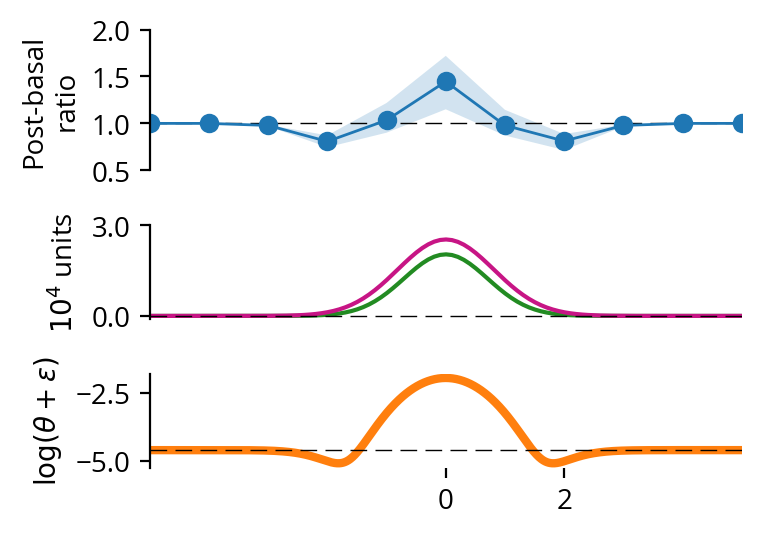

In [ ]:
fig, axs = plt.subplots(3,1, figsize=(4,3), dpi=200, height_ratios=(3,2,2))
fig.subplots_adjust(hspace=0.5, left=0.16, bottom=0.15)

mpd = deepcopy(model_p_dict)
mpd['sigma_K'] *= 1
mpd['sigma_N'] *= 1.1
mpd['Ks'] *= 1

analyze_plasticity_column(axs, mpd, [5,], 100)

# plt.savefig('docs/figures-paper/single-panels/hetero/mechanism.svg')

Text(0.5, 1.0, 'Homosynaptic LTD,\nHeterosynaptic LTD')

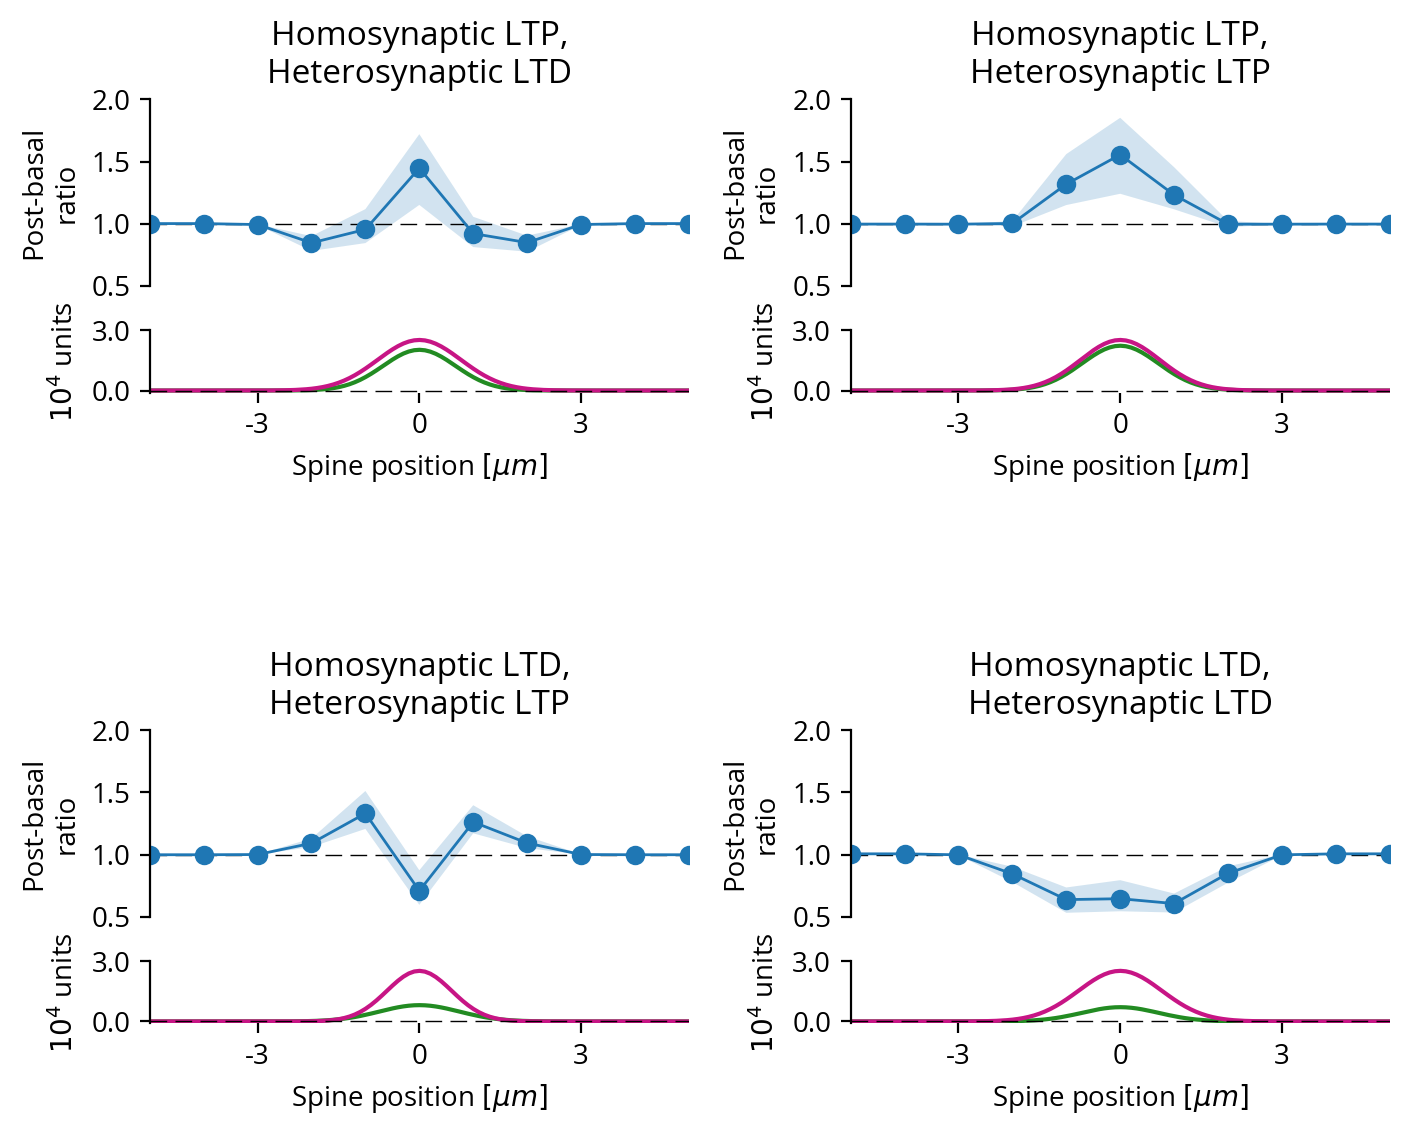

In [19]:
fig, axs = plt.subplots(5,2, height_ratios=(3,1,4,3,1), figsize=(8,6), dpi=200)
fig.subplots_adjust(wspace=0.3, hspace=0.3)


mpd = deepcopy(model_p_dict)
mpd['sigma_K'] *= 0.9
analyze_plasticity_column(axs[:2,0], mpd, [5,], 100)

mpd = deepcopy(model_p_dict)
mpd['Ks'] *= 0.4
mpd['Ns'] *= 1
mpd['sigma_N'] *= 0.6
mpd['sigma_K'] *= 1.1
analyze_plasticity_column(axs[3:,0], mpd, [5,], 100)

mpd = deepcopy(model_p_dict)
mpd['Ks'] *= 1.1
mpd['sigma_N'] *= 0.9
analyze_plasticity_column(axs[:2,1], mpd, [5,], 100)

mpd = deepcopy(model_p_dict)
mpd['Ks'] *= 0.35
mpd['Ns'] *= 1
mpd['sigma_N'] *= 1
mpd['sigma_K'] *= 1
analyze_plasticity_column(axs[3:,1], mpd, [5,], 100)

for ax in axs[2,:]: ax.remove()

axs[0,0].set_title('Homosynaptic LTP,\nHeterosynaptic LTD')
axs[0,1].set_title('Homosynaptic LTP,\nHeterosynaptic LTP')
axs[3,0].set_title('Homosynaptic LTD,\nHeterosynaptic LTP')
axs[3,1].set_title('Homosynaptic LTD,\nHeterosynaptic LTD')

# plt.savefig('docs/figures-paper/single-panels/hetero/myneighbour.svg')
